In [1]:
import sys
print(sys.version)

import sklearn.ensemble
import shap
import numpy as np
import numba
import time
import json
import xgboost
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
import shap.benchmark

from shap import TreeExplainer as TreeCext

from shap.explainers.pytree import *

3.10.6 (main, Nov  2 2022, 18:53:38) [GCC 11.3.0]


/home/jarek/projects/shap/venv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
np.set_printoptions(threshold=sys.maxsize)
# X,y = shap.datasets.communitiesandcrime()
X,y = shap.datasets.boston()
print(X.columns.values.tolist())
print(len(X.columns.values.tolist()))

print(X.shape)
print(y.shape)

['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']
13
(506, 13)
(506,)


Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np

        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i.e.
    :func:`~sklearn.datasets.fetch_california_housing`) and the Ames housing
    datase

In [7]:
# Zobaczmy na tym datasecie jaka glebokosc daje najlepsze wyszkolenie

X,y = shap.datasets.boston()
X = X.values
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

scores = {}
mean = 5

for i in range(1,13):
    pass
    print(i)
    scores[i] = 0
    for j in range(mean):
        model = sklearn.ensemble.RandomForestRegressor(n_estimators=1000, max_depth=i)
        model.fit(X_train, y_train)
        scores[i] = scores[i] + model.score(X_test, y_test)
    scores[i] = scores[i] / mean

scores

Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np

        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i.e.
    :func:`~sklearn.datasets.fetch_california_housing`) and the Ames housing
    datase

1
2


KeyboardInterrupt: 

In [ ]:
def item_generator(json_input, lookup_key):
    if isinstance(json_input, dict):
        for k, v in json_input.items():
            if k == lookup_key:
                yield v
            else:
                yield from item_generator(v, lookup_key)
    elif isinstance(json_input, list):
        for item in json_input:
            yield from item_generator(item, lookup_key)

def tree_depth(json_text):
    json_input = json.loads(json_text)
    return max(list(item_generator(json_input, 'depth'))) + 1


In [ ]:
# Zobaczmy na tym datasecie jaka glebokosc daje najlepsze wyszkolenie

X,y = shap.datasets.boston()
X = X.values
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

scores = {}
mean_depths = {}
stddev_depths = {}

mean = 10

for i in range(1,32,32):
    print(i)
    scores[i] = 0
    mean_depths[i] = 0
    stddev_depths[i] = 0
    for j in range(mean):
        model = xgboost.XGBRegressor(n_estimators=1000, max_depth=i, subsample=0.3)
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
        model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=10, verbose=False)
        scores[i] = scores[i] + model.score(X_test, y_test)
        
        booster = model.get_booster()
        tree_df = booster.trees_to_dataframe()
        print("rysuje drzewo")
        xgboost.plotting.plot_tree(booster)
        depths = [tree_depth(x) for x in booster.get_dump(dump_format = "json")]
        mean_depths[i] = mean_depths[i] + np.mean(depths)
        stddev_depths[i] = stddev_depths[i] + np.std(depths)
        
    scores[i] = scores[i] / mean
    mean_depths[i] = mean_depths[i] / mean
    stddev_depths[i] = stddev_depths[i] / mean

print(scores)
print(mean_depths)
print(stddev_depths)

In [ ]:
model = xgboost.XGBRegressor(n_estimators=1000, max_depth=5, subsample=0.3)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=10, verbose=False)

booster = model.get_booster()
tree_df = booster.trees_to_dataframe()

In [ ]:
tree_df

In [ ]:
plt.plot([x * 10 for x in scores.values()])
plt.plot(mean_depths.values())
plt.plot(stddev_depths.values())

plt.show()

# wychodza glebokosci po 13 jak da mu sie wolna reke

In [ ]:
res_shap_cext = {}
res_banz_cext = {}

time_shap_cext = {}
time_banz_cext = {}

In [ ]:
for j in range (1, 10, 2):
    if (j != 1):
        pass
    for i in range(100, 1000, 100):
        model = sklearn.ensemble.RandomForestRegressor(n_estimators=i, max_depth=13)
        model.fit(X, y)

        start = time.time()
        res_shap_cext[(i, j)] = TreeCext(model).shap_values(X, banz=False)
        time_shap_cext[(i, j)] = time.time() - start
        print(time_shap_cext[(i, j)])

        start = time.time()
        res_banz_cext[(i, j)] = TreeCext(model).shap_values(X, banz=True)
        time_banz_cext[(i, j)] = time.time() - start
        print(time_banz_cext[(i, j)])

In [3]:
def run_explain(name, explainer, data):
    start = time.time()
    values = explainer(data)
    end = time.time()
    print("name: {}, time: {}".format(name, end - start))
    return [name, values, end - start]

In [15]:
attributions = {}

for i in range(1000, 2000, 100):
    model = xgboost.XGBRegressor(n_estimators=1000, max_depth=32, subsample=0.3)
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=10, verbose=False)

    X_eval = X_test[:1]
    y_eval = y_test[:1]

    # use an independent masker
    masker = shap.maskers.Independent(X_train)
    pmasker = shap.maskers.Partition(X_train)

    explainers = [
        ("Tree", shap.explainers.Tree(model, masker)),
        ("TreeBanz", shap.explainers.Tree(model, masker, use_banz=True)),
    #     ("Tree approx.", shap.explainers.Tree(model, masker, approximate=True)),
    #     ("Exact", shap.explainers.Exact(model.predict, masker)),
    ]

    attributions[i] = [run_explain(name, exp, X_eval) for name, exp in explainers]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


ile drzew cext? 41
here37
using dense_Tree_pred
ile drzew cext? 41
here37
using dense_Tree_pred
uruchamiam z BANZ=False
using treeshap and cext
here37
using dense_Tree_pred
oto values:
[[ -17.73426748  -53.55840823 -102.155153    -80.82621202    8.86021779
   126.85078605  -33.50438032   23.71249018    6.88682444   -1.34924745
   -13.47984241  -20.62708118    5.5130738     2.04721412    0.57724193
     1.18637022]]
name: Tree, time: 0.0019099712371826172
uruchamiam z BANZ=True
using treeshap and cext
using BANZ
oto values:
[[  -8.54369509  -47.84335638 -110.97963521  -89.88662273    7.92704089
   129.83004704  -35.94092252   25.71564239    7.20483389   -2.39510907
   -16.1737053   -16.88446649    8.24587534    3.64101507   -1.19620001
     3.44431033]]
name: TreeBanz, time: 0.0004355907440185547
ile drzew cext? 41
here37
using dense_Tree_pred
ile drzew cext? 41
here37
using dense_Tree_pred
uruchamiam z BANZ=False
using treeshap and cext
here37
using dense_Tree_pred
oto values:
[[ -17.7

.values =
array([[ -17.73426748,  -53.55840823, -102.155153  ,  -80.82621202,
           8.86021779,  126.85078605,  -33.50438032,   23.71249018,
           6.88682444,   -1.34924745,  -13.47984241,  -20.62708118,
           5.5130738 ,    2.04721412,    0.57724193,    1.18637022]])

.base_values =
array([3.47413392])

.data =
array([[-0.06366149, -1.57993053, -2.83201187, -1.08342666, -0.1306204 ,
         1.40068903, -0.65165621,  0.50481546,  1.30318096,  0.12853632,
        -0.14244787, -1.30876351, -1.20247531,  0.41609963, -0.20090753,
         0.12253132]])


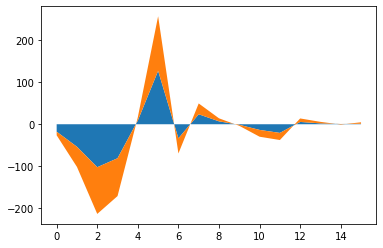

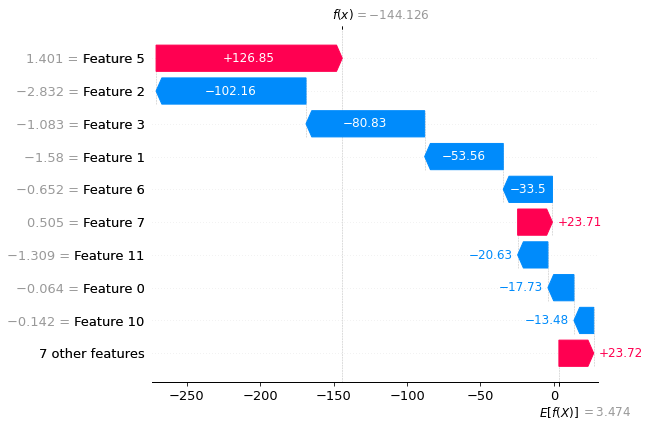

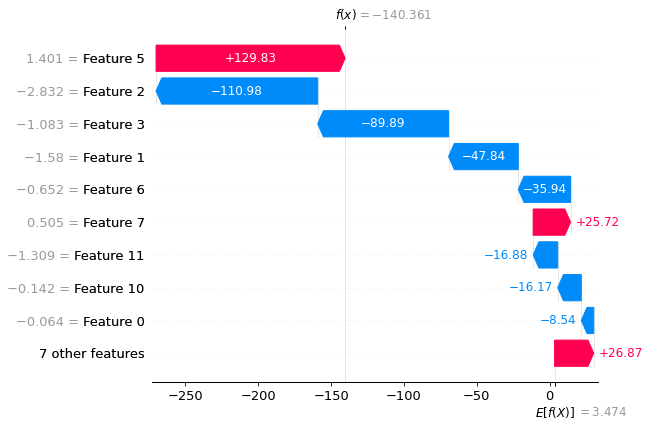

In [60]:
a = attributions[1000]
print(a[0][1])


plt.stackplot(range(len(a[0][1].values[0])), a[0][1].values[0], a[1][1].values[0])
# plt.subplot(a)
plt.show()

shap.plots.waterfall(a[0][1][0]) #tree
shap.plots.waterfall(a[1][1][0]) #treeBanz

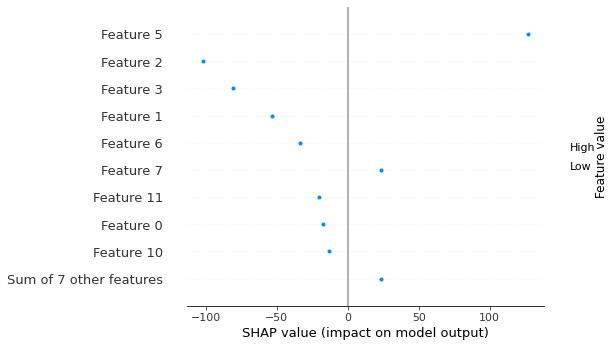

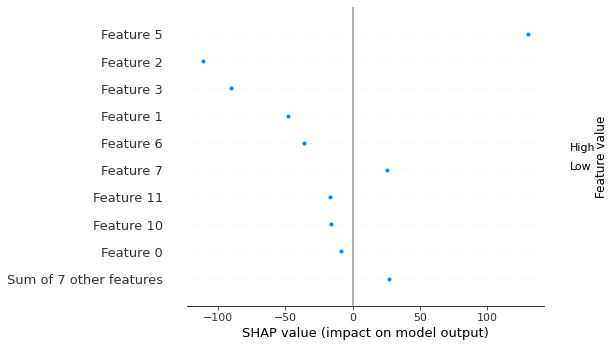

In [61]:
shap.plots.beeswarm(a[0][1])
shap.plots.beeswarm(a[1][1])

In [ ]:
# # dry run to get all the code warmed up for valid runtime measurements
# for name, exp in explainers:
#     exp(X_eval[:1])

# explain with all the explainers
attributions = [run_explain(name, exp, X_eval) for name, exp in explainers]

In [8]:
X, y = make_regression(n_samples=400, n_features=16, n_informative=8,random_state=0, shuffle=False)

model = sklearn.ensemble.RandomForestRegressor(n_estimators=1000, max_depth=10)
model.fit(X, y)

RandomForestRegressor(max_depth=10, n_estimators=1000)

In [ ]:
# bst = xgboost.train({"learning_rate": 0.01, "max_depth": 4}, xgboost.DMatrix(X, label=y), 1000)

In [ ]:
# start = time.time()
# shap_values = bst.predict(xgboost.DMatrix(X), pred_contribs=True)
# print(time.time() - start)


In [ ]:

# x = X.head()
# x = X[:1]
x = X
x

In [10]:
start = time.time()
res_shap_cext = TreeCext(model).shap_values(X, banz=False)
time_shap_cext = time.time() - start
time_shap_cext

ile drzew cext? 1000
uruchamiam z BANZ=False
using treeshap and cext
here37
using dense_Tree_pred


14.428232192993164

In [11]:
start = time.time()
res_banz_cext = TreeCext(model).shap_values(X, banz=True)
time_banz_cext = time.time() - start
time_banz_cext

ile drzew cext? 1000
uruchamiam z BANZ=True
using treeshap and cext
using BANZ


10.423633098602295

In [12]:
res_shap_cext

array([[ 3.60265163e+01,  2.09836714e+01,  3.07829010e+01,
         1.70647892e+02,  5.51735756e+01, -6.58028011e+01,
         3.36562448e+01,  3.94067604e+00,  1.63025818e+00,
         1.61808556e+00,  2.31143355e+00,  5.69456248e+00,
         2.27018044e+00,  1.39726585e+00,  5.92413671e-01,
         1.36215337e+00],
       [ 1.16230902e+01, -2.68873669e+00,  3.17827234e+01,
        -7.82476505e+01, -4.42007170e+01,  6.45240759e+01,
         1.13478572e+01, -1.54891009e+01, -3.17233934e+00,
        -2.35177964e+00, -2.17872779e-01, -2.72817955e+00,
        -9.19483034e+00, -2.21785973e-01,  6.83821191e-02,
        -5.78388048e-01],
       [-1.51846360e+01, -3.38404640e+01, -3.36235670e+01,
        -1.54358902e+00,  2.18620739e+01,  9.46422776e+01,
        -6.76157239e+00, -3.60204573e+00,  2.52716820e-01,
        -7.15473244e-01, -6.79835633e-01,  7.90539948e-01,
         7.68176469e-02,  3.48534892e-01, -2.49539134e+00,
         1.54129809e+00],
       [-2.19945826e+01, -6.07324309e

In [13]:
res_banz_cext

array([[ 3.38044631e+01,  1.93650330e+01,  2.92095064e+01,
         1.62398971e+02,  5.19296507e+01, -7.23736370e+01,
         3.06331200e+01,  2.57247072e+00,  1.37582751e+00,
         1.01407722e+00,  1.85545641e+00,  4.49225597e+00,
         1.59562420e+00,  1.31787248e+00,  2.97398840e-01,
         1.10080641e+00],
       [ 1.22715060e+01, -2.77924571e+00,  3.42103726e+01,
        -7.67326030e+01, -4.27159721e+01,  6.73783326e+01,
         1.17844488e+01, -1.50848101e+01, -3.21401019e+00,
        -2.09238346e+00,  5.64321424e-02, -2.26165306e+00,
        -7.86151455e+00, -1.71889356e-01,  1.69268823e-01,
        -2.52610305e-01],
       [-1.49839167e+01, -3.37510141e+01, -3.29087265e+01,
        -6.00177604e-01,  2.30458689e+01,  9.60894437e+01,
        -7.06255910e+00, -3.63302862e+00,  5.54385608e-01,
        -5.77969518e-01, -8.54702812e-01,  9.45977601e-01,
         1.70766042e-01,  5.18443187e-01, -2.27718644e+00,
         1.48498121e+00],
       [-2.16958358e+01, -5.16556822e

In [ ]:
ex = TreeExplainer(model)
start = time.time()
res_shap_py = ex.shap_values(x)
time_shap_py = time.time() - start

In [ ]:
start = time.time()
res_banz_py = ex.banz_values(x)
time_banz_py = time.time() - start

In [ ]:
line = np.asarray(x[:1])
ex.brute_banz(line[0], 0)

In [ ]:
ex.brute_shap(line[0], 0)

In [ ]:
results_dict_cext = {}
results_dict_cext['banz'] = {}
results_dict_cext['shap'] = {}

In [ ]:
for i in range(1, 10):
    X, y = make_regression(n_samples=200 * i, n_features=16, n_informative=8,random_state=0, shuffle=False)

    model = sklearn.ensemble.RandomForestRegressor(n_estimators=1000 + 100 * i, max_depth=10 + i)
    model.fit(X, y)
    
    start = time.time()
    res_shap_cext = TreeCext(model).shap_values(x, banz=False)
    res_shap = time.time() - start
    
    start = time.time()
    res_banz_cext = TreeCext(model).shap_values(x, banz=True)
    res_banz = time.time() - start
    
    print(res_shap)
    print(res_banz)
    results_dict_cext['banz'][i] = res_banz
    results_dict_cext['shap'][i] = res_shap
    

In [ ]:
x = [i for i in results_dict_cext['banz']]
a1 = [results_dict_cext['banz'][i] for i in results_dict_cext['banz']]
a2 = [results_dict_cext['shap'][i] for i in results_dict_cext['shap']]

y_values = {"banz": a1, "treeshap": a2}
labels = ["BANZ", "TREESHAP"]

fig, ax = plt.subplots()
ax.stackplot(x, y_values.values(), labels=labels)

ax.legend(loc='upper left')
plt.show()

In [ ]:
results_dict_py = {}
results_dict_py['banz'] = {}
results_dict_py['shap'] = {}

In [ ]:
for i in range(1, 10):
    X, y = make_regression(n_samples=100 + 25 * i, n_features=6, n_informative=2,random_state=0, shuffle=False)

    model = sklearn.ensemble.RandomForestRegressor(n_estimators=100 + 25 * i, max_depth=4)
    model.fit(X, y)
    
    ex = TreeExplainer(model)
    print('created model')
    start = time.time()
    res_shap_py = ex.shap_values(X)
    time_shap_py = time.time() - start
    
    start = time.time()
    res_banz_py = ex.banz_values(X)
    time_banz_py = time.time() - start
    
    print(res_shap_py)
    print(res_banz_py)
    results_dict_py['banz'][i] = time_banz_py
    results_dict_py['shap'][i] = time_shap_py
    

In [ ]:
x = [i for i in results_dict_py['banz']]
a1 = [results_dict_py['banz'][i] for i in results_dict_py['banz']]
a2 = [results_dict_py['shap'][i] for i in results_dict_py['shap']]

y_values = {"banz": a1, "treeshap": a2}
labels = ["BANZ", "TREESHAP"]

fig, ax = plt.subplots()
ax.stackplot(x, y_values.values(), labels=labels)

ax.legend(loc='upper left')
plt.show()

In [ ]:
len(a1)

In [ ]:
len(a2)